# Logistic Regression

**What is logistic regression?**  
Logistic Regression is a supervised machine learning algorithm used for classification: assigning a class to different sets of data.  
In statistics, the logistic model (or the logit model) is used to model the probability of data belonging in a certain class, such as species, color, pass/fail (academics), healthy/sick (health), fraudulent/not fraudulent (financial), etc.

**Dataset**  
The dataset we will be using today will be the Iris dataset.  
In the dataset, we have a few independent variables:
- Sepal Length
- Sepal Width
- Petal Length
- Petal Width

and we need to use it to predict the class/category:
- Species (Setosa, Versicolor, and Virginica)

## Loading the dataset
We shall load the dataset with Pandas from a CSV dataset that can be downloaded from the PyTorch materials website (hosted by @czlucius).

We shall change the Species column into a numerical column (0, 1 and 2), and drop the Id column as it is not useful for logistic regression.

In [1]:
import pandas as pd

df = pd.read_csv("Iris.csv")

# Let's peek into the data
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [2]:
# Since the species is not a numeric datatype, lets convert it to one:
map = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}
for row in df.iterrows():
    index = row[0]
    df.at[index, "Species"] = map[row[1]["Species"]]
# Id does not have any special relationship with the data
df = df.drop(columns="Id")
df.head()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Visualising the data

Let us visualise the data. You need not know how to use Pandas or Seaborn, the code is already provided for you, illustrating the data as diagrams.


We can see that the 2 pairs of properties that have the strongest correlation with each other:
- Petal Width and Length (0.962757)
- Petal Length and Sepal Length (0.871754)

Additionally, both petal length and width have strong correlation to species.

C:\Users\Clark\AppData\Local\Temp\ipykernel_4804\1999404440.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


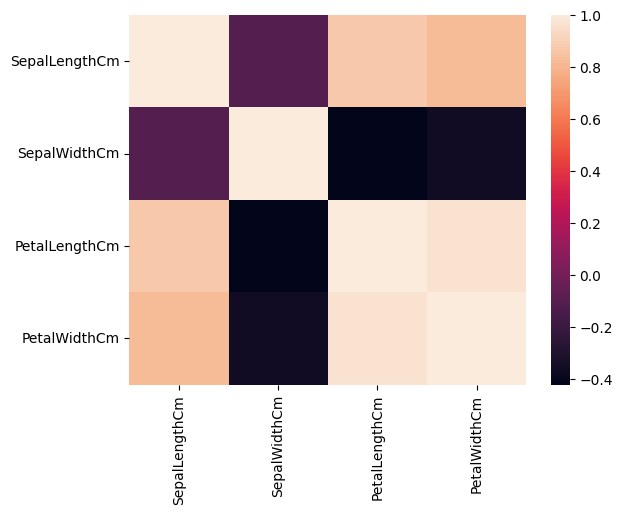

In [3]:
# Correlation between variables and species
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr())
plt.show()

<Axes: xlabel='PetalWidthCm', ylabel='PetalLengthCm'>

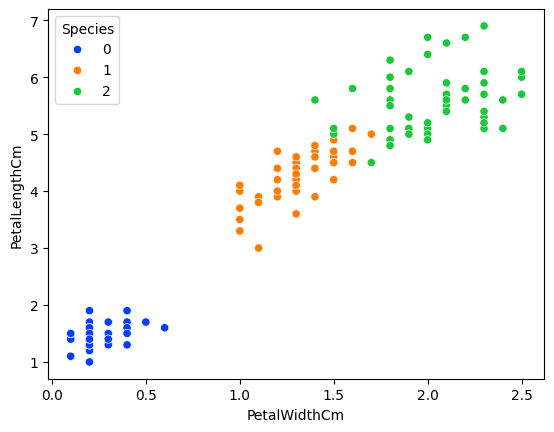

In [4]:

# Scatter
# We can see that both petal width and petal length help us to separate the species quite well, as well as that the 2 variables have strong correlation
sns.scatterplot(x='PetalWidthCm', y='PetalLengthCm', data=df, hue='Species', palette="bright")

<Axes: xlabel='Species', ylabel='PetalWidthCm'>

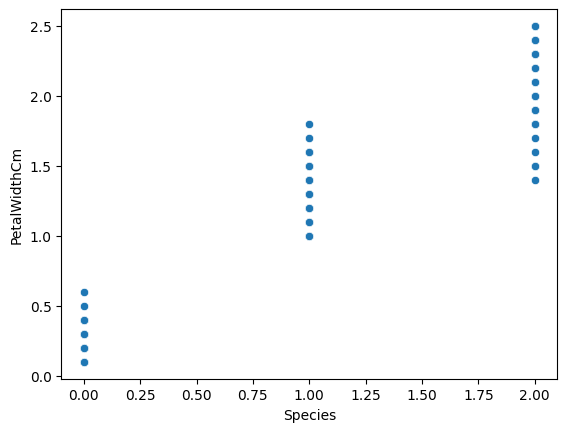

In [5]:
sns.scatterplot(x='Species', y='PetalWidthCm', data=df)
# We see an overlap between virginica and versicolor, but distinction with setosa is clear.

In [6]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, random_split
targets = torch.LongTensor(df["Species"].values.astype(np.int64))
data = torch.Tensor(df.drop("Species", axis=1).values.astype(np.float32))
data_tensor = TensorDataset(data, targets)

train_ds, test_ds = random_split(data_tensor, (0.8, 0.2))
# Let's see the first few values
train_ds_head = train_ds[0:5]
print("A peek into the data:")
print("Data", train_ds_head[0])
print("Labels", train_ds_head[1])
print(f"Train size: {len(train_ds)}")
print(f"Test size: {len(test_ds)}")

A peek into the data:
Data tensor([[6.9000, 3.1000, 5.1000, 2.3000],
        [5.8000, 2.8000, 5.1000, 2.4000],
        [6.8000, 3.0000, 5.5000, 2.1000],
        [5.1000, 3.3000, 1.7000, 0.5000],
        [5.6000, 2.7000, 4.2000, 1.3000]])
Labels tensor([2, 2, 2, 0, 1])
Train size: 120
Test size: 30


## Load the data
We shall load the data with a DataLoader in PyTorch.

In [7]:
from torch.utils.data import DataLoader
batch_size = 20
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size)

## Let's build our model
We shall now build our model.

Our input size is the number of features (independent variables), and our output size is the number of classes.  
Hence we have an input size of 4 and output size of 3.  
We shall use cross entropy loss as it is better suited for logistic regression, and SGD (Stochastic Gradient Descent) as our optimiser, and LogSoftmax

In [8]:
import torch.nn as nn
num_classes = 3
input_size = 4
learning_rate = 0.04



model = nn.Sequential(
    nn.Linear(input_size, 10) ,
    nn.LogSoftmax(),
    nn.Linear(10, num_classes),
    nn.LogSoftmax()
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), # optimize newly created model's parameters
                            lr=learning_rate)

In [9]:
# Defining the accuracy function
def accuracy_fn(output, labels):
    _, pred = torch.max(output, dim=1)
    # We find the % of labels predicted correctly out of total number of predictions
    # .item() is just to convert the tensor to an integer since it only has 1 data value
    ts = torch.tensor(torch.sum(pred == labels).item() / len(pred))
    return ts

# Defining the test function: get accuracy and loss
def test_step(model, batch):
    data, labels = batch
    output = model(data)
    loss = loss_fn(output, labels)
    accuracy = accuracy_fn(output, labels)
    return {"val_loss": loss, "val_acc": accuracy}

# Calculating mean epoch accuracy and loss
def epoch_test_results(outputs):
    batch_loss = [x["val_loss"] for x in outputs]
    mean_epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [x["val_acc"] for x in outputs]
    mean_epoch_acc = torch.stack(batch_acc).mean()
    return mean_epoch_loss, mean_epoch_acc

# Defining the evaluation function (which will be the one which is run after every epoch)
def evaluate(model, test_loader):
    outputs = []
    # Iterate through all batches of our validation data
    for batch in test_loader:
        output = test_step(model, batch)
        outputs.append(output)

    return epoch_test_results(outputs)



In [12]:
import time
# Training the model
n_epochs = 100
loss_values=[]
mea = []
model.train() # Specify that we are in training mode
for epoch in range(n_epochs):
    for batch in train_loader:
        # Calculating loss of prediction
        data, labels = batch # Our batch has both data and labels.
        output = model(data)
        loss = loss_fn(output, labels)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    result = evaluate(model, test_loader)
    print("Result", result)
    mean_epoch_loss, mean_epoch_acc = result
    print(f"Epoch {epoch} - validation loss: {mean_epoch_loss}, validation accuracy: {mean_epoch_acc}")
    loss_values.append(mean_epoch_loss.item())
    mea.append(mean_epoch_acc.item())
    time.sleep(0.1)


Result (tensor(0.0598, grad_fn=<MeanBackward0>), tensor(1.))
Epoch 0 - validation loss: 0.05981232598423958, validation accuracy: 1.0
Result (tensor(0.1308, grad_fn=<MeanBackward0>), tensor(0.9500))
Epoch 1 - validation loss: 0.13081929087638855, validation accuracy: 0.949999988079071
Result (tensor(0.0594, grad_fn=<MeanBackward0>), tensor(1.))
Epoch 2 - validation loss: 0.05937333032488823, validation accuracy: 1.0
Result (tensor(0.0516, grad_fn=<MeanBackward0>), tensor(1.))
Epoch 3 - validation loss: 0.05160457640886307, validation accuracy: 1.0
Result (tensor(0.1207, grad_fn=<MeanBackward0>), tensor(0.9500))
Epoch 4 - validation loss: 0.12067729979753494, validation accuracy: 0.949999988079071
Result (tensor(0.2693, grad_fn=<MeanBackward0>), tensor(0.8250))
Epoch 5 - validation loss: 0.2692692279815674, validation accuracy: 0.8250000476837158
Result (tensor(0.0624, grad_fn=<MeanBackward0>), tensor(1.))
Epoch 6 - validation loss: 0.06238918378949165, validation accuracy: 1.0
Result (

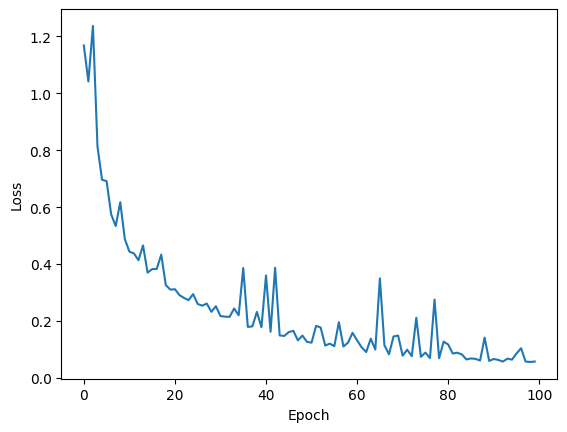

In [11]:
loss_values = np.array(loss_values)
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

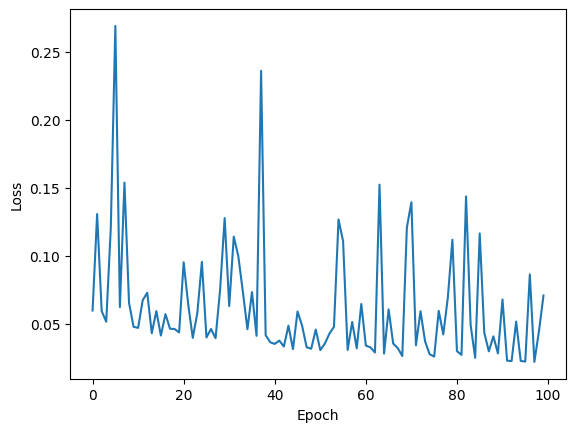

In [13]:
# next 100

loss_values = np.array(loss_values)
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
loss_values = np.array(mea)
plt.plot(mea)
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.show()

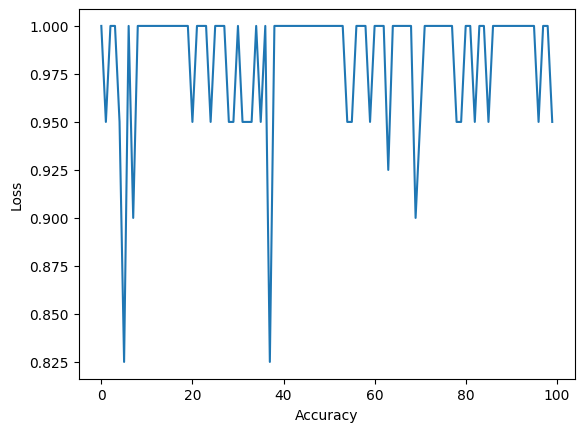

In [14]:
# next 100
loss_values = np.array(mea)
plt.plot(mea)
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.show()

## Inference

We shall now get an inference out of the model we have trained.  
Inference refers to using the model to predict results.

In [18]:
entry = test_ds[25] # change index here
print(entry)
entry_data = entry[0]
print(entry_data)
output = model(entry_data)
print(output)
# preds will be the index of the prediction.
_, preds = torch.max(output, dim=0)
classes = ["Setosa", "Versicolor", "Virginica"]
print(f"My prediction is {classes[preds]}, actual is {classes[entry[1]]}")

(tensor([6.3000, 2.7000, 4.9000, 1.8000]), tensor(2))
tensor([6.3000, 2.7000, 4.9000, 1.8000])
tensor([-10.7844,  -0.5814,  -0.8190], grad_fn=<LogSoftmaxBackward0>)
My prediction is Versicolor, actual is Virginica


In [16]:
for i in range(1,149):
    entry = test_ds[i]
    entry_data = entry[0]
    output = model(entry_data)
    _, preds = torch.max(output, dim=0)
    classes = ["Setosa", "Versicolor", "Virginica"]
    if classes[preds] != classes[entry[1]]:
        print(f'Wrong prediction at entry #{i}')

Wrong prediction at entry #25


IndexError: list index out of range